In [5]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

In [6]:
import tensorflow as tf
import numpy as np
import gradio as gr

from emnist import extract_training_samples
training_images, training_labels = extract_training_samples("balanced")
from emnist import extract_test_samples
testing_images, testing_labels = extract_test_samples("balanced")

training_images = training_images / 255.0
testing_images = testing_images / 255.0
training_images = np.expand_dims(training_images, axis=3)
testing_images = np.expand_dims(testing_images, axis=3)
num_filters = 32
kernel_size = (3, 3)
pool_size = (2, 2)

model = tf.keras.Sequential([ # Reverted to keras 2.6.0 due to AlreadyExistsError
    tf.keras.layers.Conv2D(num_filters, kernel_size, activation="relu"),
    tf.keras.layers.MaxPooling2D(pool_size),
    tf.keras.layers.Conv2D(num_filters, kernel_size, activation="relu"),
    tf.keras.layers.MaxPooling2D(pool_size),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(47, activation="softmax")
])
model.compile(optimizer="Adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.fit(training_images, training_labels, epochs=5)

Epoch 4/5
3525/3525 [==============================] - 130s 37ms/step - loss: 0.3144 - accuracy: 0.8839
Epoch 5/5
3525/3525 [==============================] - 241s 68ms/step - loss: 0.2867 - accuracy: 0.8932


In [12]:
import cv2
import functools
from keras.preprocessing.image import img_to_array
%matplotlib inline
import matplotlib.pyplot as plt
class_mapping = "0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabdefghnqrt"
TARGET_HEIGHT = 28
TARGET_WIDTH = 28

In [13]:
def class_idx_to_class(class_idx):
    class_mapping = "0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabdefghnqrt"
    return class_mapping[class_idx]

def classify(image):
    image = tf.math.divide(image, 255)
    prediction = model.predict(image.reshape(-1, 28, 28, 1))[0]
    return {str(class_idx_to_class(i)): float(prediction[i]) for i in range(47)}

In [48]:
def classify_word(input):
    # final word/string to return 
    classification = ""
    # apply thresholding to make differences between characters and background more obvious
    image = cv2.imwrite('file.png', input) # switched from jpg to png
    image = cv2.imread("file.png", 0)

    throwaway, threshold = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # find contours and get bounding box
    contours, _ = cv2.findContours(threshold.copy(), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(threshold, contours, -1, (0, 255, 0), thickness=1)
    boundingBoxes = [cv2.boundingRect(contour) for contour in contours]

    # sort bounding boxes from left to right and top to bottom so characters are read in the correct order
    boundingBoxes=sorted(boundingBoxes, key=functools.cmp_to_key(compare))
    # loop over bounding boxes
    for rect in boundingBoxes:
        # get coordinates from the bounding box
        x, y, w, h = rect

        # only process if size of character is large enough
        if w * h > 30:
            # crop to only have the character
            crop = image[y:y+h, x:x+w]

            # ensure each character is the correct size for our model (28 x 28) by adding padding
            rows = crop.shape[0]
            columns = crop.shape[1]
            paddingX = (TARGET_HEIGHT - rows) // 2 if rows < TARGET_HEIGHT else rows
            paddingY = (TARGET_WIDTH - columns) // 2 if columns < TARGET_WIDTH else columns

           # add padding 
            crop = cv2.copyMakeBorder(crop, paddingY, paddingY, paddingX, paddingX, cv2.BORDER_CONSTANT, None, value=0)

            # convert and resize image to target height and width
            crop = cv2.resize(crop, (TARGET_WIDTH, TARGET_HEIGHT))
        
            # format image data to make prediction
            crop = img_to_array(crop)
            char = crop.reshape((-1, 28, 28, 1))
            
            plt.figure(figsize=(2,2))
            plt.imshow(crop, cmap='gray')

            # make prediction, add to classification string
            char = tf.math.divide(char, 255.0)
            prediction = model.predict(char)[0]
            #dictionary = {str(class_mapping[i]): float(prediction[i]) for i in range(47)}
            classification += class_mapping[np.argmax(prediction)]
    
    return classification

def compare(rect1, rect2):
    if abs(rect1[1] - rect2[1]) > 10:
        return rect1[1] - rect2[1]
    else:
        return rect1[0] - rect2[0]

In [49]:
# Addition of handwriting generation
char_dict = dict.fromkeys(list(class_mapping))
for i in range(training_labels.shape[0]):
    label = class_idx_to_class(training_labels[i])
    image = training_images[i]
    if char_dict[label] is None:
        char_dict[label] = [i]
    else:
        char_dict[label].append(i)

from random import randint

unique_handwriting = dict.fromkeys(list(class_mapping))

# Generates a unique handwriting dictionary from char_dict
def generate_chars():
    unique_handwriting.clear()
    for key in char_dict.keys():
        index = char_dict[key][randint(0, len(char_dict[key])-1)]
        unique_handwriting[key] = index
    return unique_handwriting

# Generates a handwritten sentence given a word input (utilizes unique handwriting)
def generate_image_from_word(input_word):
    handwriting = generate_chars()
    image = np.zeros((28,28,1))
    for char in input_word:
        if char == ' ':
            image = np.concatenate((image,np.zeros((28,28,1))), 1)
        else:
            if char not in "abdefghnqrt":
                char = char.upper()
            image = np.concatenate((image,training_images[handwriting[char]]), 1)
    image = image[0:,28:]
    return image

actual: Tensor Flow
predict: IIIIIIIIIIII


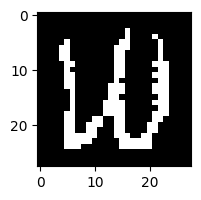

In [52]:
new_label = "Tensor Flow"
new_image = generate_image_from_word(new_label)
plt.figure(figsize=(28, 3))
plt.imshow(new_image, cmap='gray')
print("actual:", new_label)
print("predict:", classify_word(new_image))

Running on local URL:  http://127.0.0.1:7867/
Running on public URL: https://30803.gradio.app

This share link will expire in 72 hours. To get longer links, send an email to: support@gradio.app


KeyboardInterrupt: KeyboardInterrupt: 

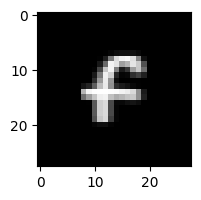

In [53]:
image = gr.inputs.Image(shape=(28, 28), image_mode="L", invert_colors=True, source="canvas", type="numpy")

label = gr.outputs.Label(num_top_classes=3)

interface = gr.Interface(fn=classify_word, inputs=image, outputs=label, capture_session=True)
interface.launch(share=True, debug=True)